In [1]:
"""In this notebook
I play with a dropout MLP model for pytorch,i found from internet.
I want to use this as basis for other things i will do with Dropout for my mnist like project.
"""
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        super(CustomDropout, self).__init__()
        self.p = p
        # multiplier is 1/(1-p). Set multiplier to 0 when p=1 to avoid error...
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0-p)
        else:
            self.multiplier_ = 0.0
    def forward(self, input):
        # if model.eval(), don't apply dropout
        if not self.training:
            return input
        
        # So that we have `input.shape` numbers of Bernoulli(1-p) samples
        selected_ = torch.Tensor(input.shape).uniform_(0,1)>self.p
        
        # To support both CPU and GPU.
        if input.is_cuda:
            selected_ = Variable(selected_.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ = Variable(selected_.type(torch.FloatTensor), requires_grad=False)
            
        # Multiply output by multiplier as described in the paper [1]
        return torch.mul(selected_,input) * self.multiplier_

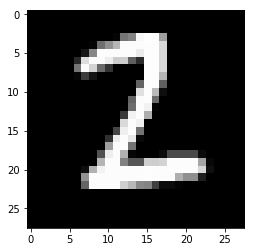

In [3]:
#load a pytorch dataset without tranforming
transform = transforms.Compose([transforms.ToTensor()])
trainset2 = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=64, shuffle=True, num_workers=2)
dataiter2 = iter(trainloader2)
images2, labels2 = dataiter2.next()
plt.imshow(images2[0].squeeze(),cmap="gray")

In [4]:
#transform = transforms.Compose([transforms.ToTensor(), \
#                                transforms.Normalize((0, 0, 0), (1, 1, 1))])

transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

#pytorch loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()

labels tensor(4)
torch.Size([1, 28, 28])


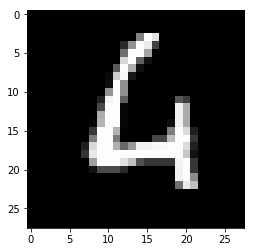

In [5]:
print("labels",labels[0])
print(images[0].shape)
plt.imshow(images[0].squeeze(),cmap="gray")

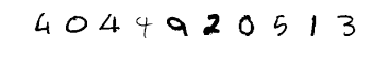

label: [4 0 4 4 9 2 0 5 1 3]
image data shape: (1, 28, 28)


In [6]:
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(images[i].numpy().squeeze(),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()
print('label:',labels[:10].numpy())
print('image data shape:',images[0].numpy().shape)

In [7]:
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("dropout0",CustomDropout(p=droprates[0]))
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("tanh", nn.Tanh())
        
        # Add hidden layers
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden"+str(i+1), CustomDropout(p=droprates[1]))
            self.model.add_module("hidden"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))        
        
    def forward(self, x):
        # Turn to 1D
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x

In [8]:
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=128, max_epoch=10, \
                 lr=0.1, momentum=0):
        # Wrap MLP model
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates)
        #self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        # Training, make sure it's on GPU, otherwise, very slow...
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test #.cuda()
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                #print("loss.data[0]",loss.data)
                running_loss += loss.data
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            #print("y_test",y_test)
            #print("y_test_pred",y_test_pred)
            #print("y_test == y_test_pred",(y_test == y_test_pred))
            #print("y_test == y_test_pred",(y_test == y_test_pred).shape)
            self.test_accuracy.append(np.mean( (y_test == y_test_pred).numpy() ))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        # Used to keep all test errors after each epoch
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)

In [20]:
hidden_layers = [800, 800]

mlp_classifier = MLPClassifier(hidden_layers, droprates=[0.3, 0.5], max_epoch=20)

In [21]:
print(mlp_classifier.model)

MLP(
  (model): Sequential(
    (dropout0): CustomDropout()
    (input): Linear(in_features=784, out_features=800, bias=True)
    (tanh): Tanh()
    (dropout_hidden1): CustomDropout()
    (hidden1): Linear(in_features=800, out_features=800, bias=True)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10, bias=True)
  )
)


In [22]:
mlp_classifier.fit(trainset, testset,verbose=True) 

Epoch 1 loss: 0.582422137260437
Test error: 937; test accuracy: 0.9063
Epoch 2 loss: 0.4148445129394531
Test error: 838; test accuracy: 0.9161
Epoch 3 loss: 0.36639198660850525
Test error: 736; test accuracy: 0.9264
Epoch 4 loss: 0.3174746334552765
Test error: 618; test accuracy: 0.9381
Epoch 5 loss: 0.27344056963920593
Test error: 558; test accuracy: 0.9441
Epoch 6 loss: 0.2490393966436386
Test error: 504; test accuracy: 0.9496
Epoch 7 loss: 0.2256380319595337
Test error: 454; test accuracy: 0.9545
Epoch 8 loss: 0.20543135702610016
Test error: 376; test accuracy: 0.9623
Epoch 9 loss: 0.1898466944694519
Test error: 365; test accuracy: 0.9634
Epoch 10 loss: 0.1771884560585022
Test error: 331; test accuracy: 0.9669
Epoch 11 loss: 0.16817300021648407
Test error: 331; test accuracy: 0.9669
Epoch 12 loss: 0.1592063009738922
Test error: 294; test accuracy: 0.9705
Epoch 13 loss: 0.15038157999515533
Test error: 295; test accuracy: 0.9704
Epoch 14 loss: 0.14184556901454926
Test error: 275; test

In [11]:
mlp_classifier.fit(trainset, testset,verbose=True) 

Epoch 1 loss: 0.5032181143760681
Test error: 937; test accuracy: 0.9063
Epoch 2 loss: 0.32592859864234924
Test error: 850; test accuracy: 0.9149
Epoch 3 loss: 0.2760166525840759
Test error: 633; test accuracy: 0.9367
Epoch 4 loss: 0.23245476186275482
Test error: 628; test accuracy: 0.9371
Epoch 5 loss: 0.2008836716413498
Test error: 493; test accuracy: 0.9507
Epoch 6 loss: 0.17545178532600403
Test error: 435; test accuracy: 0.9564
Epoch 7 loss: 0.1564868539571762
Test error: 380; test accuracy: 0.962
Epoch 8 loss: 0.14121775329113007
Test error: 416; test accuracy: 0.9583
Epoch 9 loss: 0.1291002780199051
Test error: 353; test accuracy: 0.9647
Epoch 10 loss: 0.12059856951236725
Test error: 325; test accuracy: 0.9674
Epoch 11 loss: 0.10960168391466141
Test error: 326; test accuracy: 0.9673
Epoch 12 loss: 0.10118421912193298
Test error: 283; test accuracy: 0.9716
Epoch 13 loss: 0.09508046507835388
Test error: 283; test accuracy: 0.9716
Epoch 14 loss: 0.08917289972305298
Test error: 259; t

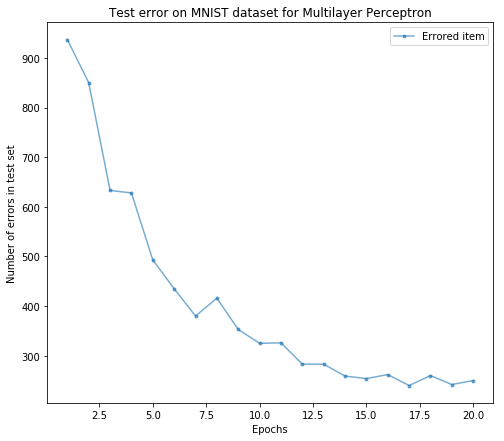

In [13]:
plt.figure(figsize=(8, 7))

plt.plot(range(1, len(mlp_classifier.test_error)+1), mlp_classifier.test_error, '.-', label="Errored item", alpha=0.6);

plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test error on MNIST dataset for Multilayer Perceptron')
plt.show()